In [1]:
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split as tts   
from sklearn.metrics import mean_squared_error as mse   
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.tree import ExtraTreeRegressor as ETR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
from catboost import CatBoostRegressor as CTR
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso    
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet 


In [3]:
muestra=pd.read_csv('../data/muestra.csv')


In [4]:
muestra.head()

,id,salary_in_usd
0,0,70377
1,1,85839
2,2,63613
3,3,88561
4,4,37621


In [5]:
salaries = pd.read_csv('../data/salaries_data.csv')

In [6]:
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Engineer,140250,USD,140250,US,100,US,M
1,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
2,2021,MI,FT,BI Data Analyst,100000,USD,100000,US,100,US,M
3,2021,MI,CT,ML Engineer,270000,USD,270000,US,100,US,L
4,2021,MI,FT,Data Engineer,22000,EUR,26005,RO,0,US,L


In [7]:
testeo = pd.read_csv('../data/testeo.csv')

In [8]:
testeo.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2020,SE,FT,Machine Learning Scientist,260000,USD,JP,0,JP,S
1,2020,MI,FT,Lead Data Analyst,87000,USD,US,100,US,L
2,2020,MI,FT,Data Analyst,85000,USD,US,100,US,L
3,2020,MI,FT,Machine Learning Engineer,299000,CNY,CN,0,CN,M
4,2020,MI,FT,Product Data Analyst,450000,INR,IN,100,IN,L


In [9]:
salaries.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           500 non-null    int64 
 1   experience_level    500 non-null    object
 2   employment_type     500 non-null    object
 3   job_title           500 non-null    object
 4   salary              500 non-null    int64 
 5   salary_currency     500 non-null    object
 6   salary_in_usd       500 non-null    int64 
 7   employee_residence  500 non-null    object
 8   remote_ratio        500 non-null    int64 
 9   company_location    500 non-null    object
 10  company_size        500 non-null    object
dtypes: int64(4), object(7)
memory usage: 224.3 KB


In [10]:
salaries.shape

(500, 11)

In [11]:
testeo.shape

(107, 10)

In [12]:
salaries2 = salaries.copy()


In [13]:
stats=salaries2.describe().T
stats['IQR']=stats['75%']-stats['25%']
outliers=pd.DataFrame(columns=stats.index)
for c in stats.index:
    iqr=stats.at[c, 'IQR']
    cutoff=1.5 * iqr   # test de tukey
    lower=stats.at[c, '25%'] - cutoff
    upper=stats.at[c, '75%'] + cutoff
    res=salaries2[(salaries2[c] < lower) | (salaries2[c] > upper)].copy()
    res['outliers']=c
    outliers=outliers.append(res, sort=True)
outliers['outliers'].value_counts()
clean_index=[i for i in salaries2.index if i not in outliers.index]
salaries2=salaries2.iloc[clean_index]

/var/folders/0p/q9p3n_m96v7fgw9v0l4dvkyr0000gn/T/ipykernel_27318/1326823474.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers=outliers.append(res, sort=True)
/var/folders/0p/q9p3n_m96v7fgw9v0l4dvkyr0000gn/T/ipykernel_27318/1326823474.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers=outliers.append(res, sort=True)
/var/folders/0p/q9p3n_m96v7fgw9v0l4dvkyr0000gn/T/ipykernel_27318/1326823474.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers=outliers.append(res, sort=True)
/var/folders/0p/q9p3n_m96v7fgw9v0l4dvkyr0000gn/T/ipykernel_27318/1326823474.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outli

In [14]:
y=salaries2.salary_in_usd

In [15]:
salaries2.drop('salary_in_usd',axis=1,inplace=True)

In [16]:
#salaries2.drop(['salary','salary_currency'],axis=1,inplace=True)

In [17]:
salaries2.shape

(463, 10)

In [18]:
salaries3 = pd.concat([salaries2, testeo]).reset_index()

In [19]:
salaries3.drop('index',axis=1,inplace=True)

In [20]:
salaries3.shape

(570, 10)

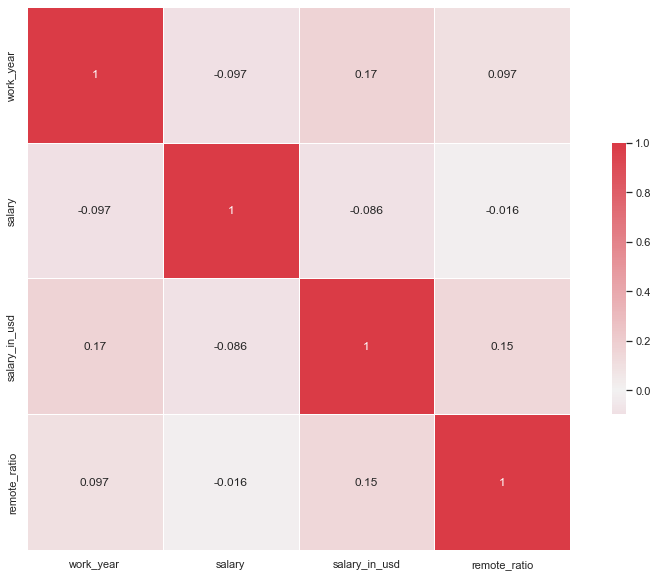

In [21]:
plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(salaries3.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(salaries.corr(),
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

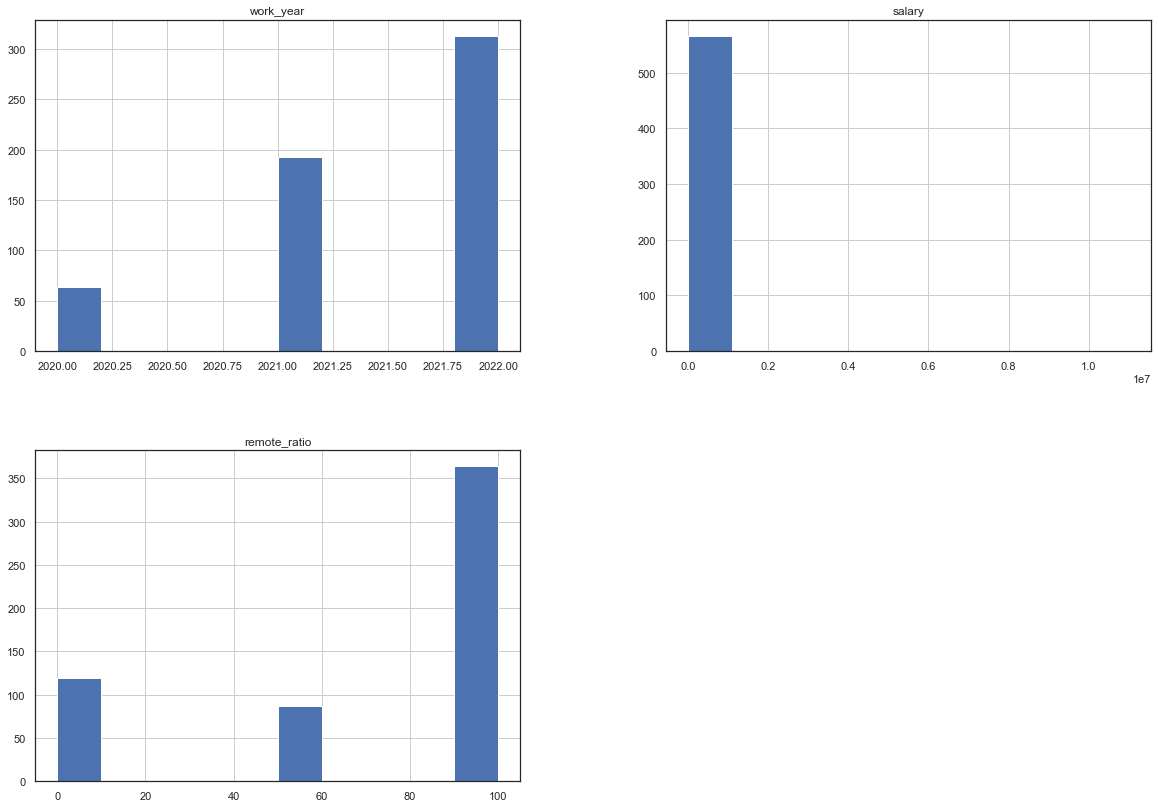

In [22]:
_ = salaries3.hist(figsize=(20, 14))

In [23]:
salaries3["experience_level"].value_counts()

SE    272
MI    198
EN     78
EX     22
Name: experience_level, dtype: int64

In [24]:
salaries3["employment_type"].value_counts()

FT    553
PT      9
CT      4
FL      4
Name: employment_type, dtype: int64

In [25]:
salaries3["employee_residence"].value_counts()

US    323
GB     44
CA     29
DE     25
FR     18
ES     15
GR     13
IN      7
PT      6
PK      6
BR      6
NL      5
PL      4
RU      4
JP      4
IT      4
VN      3
AE      3
TR      3
AU      3
AT      3
BE      2
MX      2
SI      2
DK      2
NG      2
RO      2
SG      2
MT      1
MY      1
BO      1
AR      1
LU      1
CN      1
HR      1
HN      1
HU      1
IQ      1
CO      1
PH      1
HK      1
RS      1
IR      1
DZ      1
PR      1
CZ      1
EE      1
BG      1
UA      1
NZ      1
JE      1
CH      1
KE      1
IE      1
MD      1
TN      1
Name: employee_residence, dtype: int64

In [26]:
salaries3["company_size"].value_counts()

M    318
L    178
S     74
Name: company_size, dtype: int64

In [27]:
salaries3.drop(['salary','salary_currency'],axis=1,inplace=True)

In [29]:
salaries3.drop('employee_residence',axis=1, inplace=True)

In [ ]:
salaries3.head()

In [30]:
salaries3=pd.get_dummies(salaries3, columns=['experience_level', 'employment_type', 'job_title',\
                                         'company_location', 'company_size'], drop_first=True)

In [ ]:

salaries3.head()

In [32]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

In [34]:
salaries3[['work_year','remote_ratio']] = scaler.fit_transform(salaries3[['work_year','remote_ratio']])


In [35]:
salaries3.shape

(570, 102)

In [37]:
salaries3.head()

,work_year,remote_ratio,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,job_title_Analytics Engineer,job_title_Applied Data Scientist,...,company_location_RO,company_location_RU,company_location_SG,company_location_SI,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_M,company_size_S
0,0.820950,0.700449,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.820950,0.700449,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,-0.636812,0.700449,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,-0.636812,0.700449,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.636812,-1.756510,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [38]:
salaries4 = salaries3.iloc[0:463]
testeofin= salaries3.iloc[463:]

In [39]:
salaries4 = salaries3.iloc[:463,:]
testeofin= salaries3.iloc[463:,:]

In [40]:
salaries4.shape

(463, 102)

In [41]:
testeofin.shape

(107, 102)

In [42]:
y.shape

(463,)

In [43]:
x_train, x_test, y_train, y_test = tts(salaries4, y, train_size=0.8, test_size=0.2, random_state=22)

In [44]:
def predecir(x_train, x_test, y_train, y_test):
    #inicializamos todos los modelos que vamos a probar
    svr=SVR()
    rfr=RFR()
    etr=ETR()
    gbr=GBR()
    xgbr=XGBR()
    ctr=CTR()
    linreg=LinReg()
    lasso=Lasso()
    ridge=Ridge()
    elastic=ElasticNet()
    #los entrenamos
    svr.fit(x_train, y_train)
    rfr.fit(x_train, y_train)
    etr.fit(x_train, y_train)
    gbr.fit(x_train, y_train)
    xgbr.fit(x_train, y_train)
    ctr.fit(x_train, y_train, verbose=0)
    linreg.fit(x_train, y_train)
    lasso.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    elastic.fit(x_train, y_train)
    #predecimos
    y_pred1 = svr.predict(x_test)
    y_pred2 = rfr.predict(x_test)
    y_pred3 = etr.predict(x_test)
    y_pred4 = gbr.predict(x_test)
    y_pred5 = xgbr.predict(x_test)
    y_pred6 = ctr.predict(x_test)
    y_pred7 = linreg.predict(x_test)
    y_pred8 = lasso.predict(x_test)
    y_pred9 = ridge.predict(x_test)
    y_pred10 = elastic.predict(x_test)
    #calculamos error cuadrático medio (mse)
    mse1 = mse(y_test, y_pred1, squared=False)
    mse2 = mse(y_test, y_pred2, squared=False)
    mse3 = mse(y_test, y_pred3, squared=False)
    mse4 = mse(y_test, y_pred4, squared=False)
    mse5 = mse(y_test, y_pred5, squared=False)
    mse6 = mse(y_test, y_pred6, squared=False)
    mse7 = mse(y_test, y_pred7, squared=False)
    mse8 = mse(y_test, y_pred8, squared=False)
    mse9 = mse(y_test, y_pred9, squared=False)
    mse10 = mse(y_test, y_pred10, squared=False)
    #creamos una lista con todos los mse
    temp = [mse1, mse2, mse3, mse4, mse5, mse6, mse7, mse8, mse9, mse10]
    #pedimos a la función que nos devuelva el valor más bajo de mse
    minimo = min(temp)
    #le ponemos un mensajito para que quede más mono
    if minimo == mse1:
        return f'El mejor modelo es SVR con un mse de {mse1}'
    elif minimo == mse2:
        return f'El mejor modelo es RFR con un mse de {mse2}'
    elif minimo == mse3:
        return f'El mejor modelo es ETR con un mse de {mse3}'
    elif minimo == mse4:
        return f'El mejor modelo es GBR con un mse de {mse4}'
    elif minimo == mse5:
        return f'El mejor modelo es XGBR con un mse de {mse5}'
    elif minimo == mse6:
        return f'El mejor modelo es CTR con un mse de {mse6}'
    elif minimo == mse7:
        return f'El mejor modelo es LINREG con un mse de {mse7}'
    elif minimo == mse8:
        return f'El mejor modelo es LASSO con un mse de {mse8}'
    elif minimo == mse9:
        return f'El mejor modelo es RIDGE con un mse de {mse9}'
    elif minimo == mse10:
        return f'El mejor modelo es ELASTIC con un mse de {mse10}'

In [45]:
predecir(x_train, x_test, y_train, y_test)

'El mejor modelo es RIDGE con un mse de 34207.94432400609'

In [46]:
ridge=Ridge()

In [47]:
ridge.fit(x_train, y_train)


Ridge()

In [48]:
y_pred19 = ridge.predict(x_test)


In [49]:
mse18 = mse(y_test, y_pred19, squared=False)


In [50]:
mse18

34207.94432400609

In [51]:
y_pred_test16 = ridge.predict(testeofin)

In [52]:
muestra.salary_in_usd = y_pred_test16

In [ ]:
error16 = muestra.copy()

In [ ]:
error16.to_csv('../data/error16.csv', index=False)


# Esto son cosas que he probado pero no han servido

In [ ]:
#jobs = salaries3["job_title"].value_counts()


In [ ]:
'''def limpiar_job(column):
    if 'Scientist' in column:
        return 'Data Scientist'
    elif 'Engineer' in column:
        return 'Data Engineer'
    elif 'Analyst' in column:
        return 'Data Analyst '
    else:
        return 'Machine Learning Engineer' '''

In [ ]:
#salaries3['job_title'] = salaries3['job_title'].apply(limpiar_job)

In [ ]:
#from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
#salaries3.company_location=LabelEncoder().fit_transform(salaries3.company_location)
#salaries3.job_title=LabelEncoder().fit_transform(salaries3.job_title)
#salaries3.employment_type=LabelEncoder().fit_transform(salaries3.employment_type)
#salaries3.experience_level=LabelEncoder().fit_transform(salaries3.experience_level)


In [ ]:
'''super_high = ['US','NZ','CA','CA','AE','CN','DZ','SG','DK','JP','AU','BE']
high = ['DE','GB','AT','PL','IE','CZ','FR','CH','SI','RO','NL']
medium=['GR','ES','PT','LU','CL','HU','EE','IN','NG','MT'] '''

In [ ]:
'''new_location = []
for e in salaries3.company_location:
    if e in super_high:
        new_location.append('super_high')
    elif e in high:
        new_location.append('high')
    elif e in medium:
        new_location.append('medium')
    else:
        new_location.append('low') '''

In [ ]:
#salaries3.company_location = new_location

# De aqui para abajo nada de nada 

In [ ]:
#salaries.groupby('experience_level').mean()

In [ ]:
#salaries3.describe(include='all').T

In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['company_size'], drop_first=True)

#salaries3.head()

In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['experience_level'], drop_first=True)


In [ ]:
#salaries3.job_title.value_counts()

In [ ]:
'''def limpiar_job(column):
    if 'Scientist' in column:
        return 'Data Scientist'
    elif 'Engineer' in column:
        return 'Data Engineer'
    elif 'Analyst' in column:
        return 'Data Analyst '
    else:
        return 'Machine Learning Engineer' '''

In [ ]:
#salaries3['job_title'] = salaries3['job_title'].apply(limpiar_job)

In [ ]:
#salaries3.job_title.value_counts()

In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['job_title'], drop_first=True)


In [ ]:
#salaries3.employment_type.value_counts()

In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['employment_type'], drop_first=True)



In [ ]:
#salaries3.drop('employee_residence',axis=1,inplace=True)

In [ ]:
#salaries3["company_location"].value_counts()

In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['employee_residence'], drop_first=True)



In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['company_location'], drop_first=True)



In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['remote_ratio'], drop_first=True)



In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['work_year'], drop_first=True)



In [ ]:
#prueba = salaries.groupby('company_location').mean()
#prueba = prueba.reset_index()
#prueba

In [ ]:
#sorted_countries = list(salaries2["company_location"].value_counts().index)
#number_of_employees = salaries2["company_location"].value_counts()
#len(number_of_employees)

In [ ]:
#prueba["company_location"] = pd.Categorical(prueba["company_location"], categories = sorted_countries)
#a = prueba.sort_values(by = "company_location")
#a
#a

In [ ]:
#b =  a.sort_values(by=['salary_in_usd'], ascending=False)
#a['company_location'] = number_of_employees.values
#a
#b
#super_high = ['US','NZ','CA','CA','AE','CN','DZ','SG','DK','JP','AU','BE']
#high = ['DE','GB','AT','PL','IE','CZ','FR','CH','SI','RO','NL']
#medium=['GR','ES','PT','LU','CL','HU','EE','IN','NG','MT']


In [ ]:
#a['mean_salary']= a['salary_in_usd']/a['employee_number']
#a

In [ ]:
#number_of_employees.values

In [ ]:
#b =  a.sort_values(by=['salary_in_usd'], ascending=False)
#b['number'] = number_of_employees.values
#b

In [ ]:
#Esto no porque da una media de salario para algunos paises que no tiene sentido 
#b['mean_salary']= b['salary_in_usd']/b['number']
#b

In [ ]:
#b.describe(include='all').T

In [ ]:
'''
new_company=[]
for e in b.salary_in_usd:
    if e>= 85501.152174 and e <= 144892.682434: 
        new_company.append('high')
    elif e>= 54945.75 and e<= 85501.152174:
        new_company.append('medium')
    elif e >= 24911.25 and e<= 54945.75:
        new_company.append('low')
    else:
        new_company.append('super_low') '''

In [ ]:
#b.company_location= new_company

In [ ]:
#salaries3.company_location=b.company_location

In [ ]:
#salaries3

In [ ]:
#super_high = ['US','NZ','CA','CA','AE','CN','DZ','SG','DK','JP','AU','BE']
#high = ['DE','GB','AT','PL','IE','CZ','FR','CH','SI','RO','NL']
#medium=['GR','ES','PT','LU','CL','HU','EE','IN','NG','MT']

In [ ]:
'''new_location = []
for e in salaries3.company_location:
    if e in super_high:
        new_location.append('super_high')
    elif e in high:
        new_location.append('high')
    elif e in medium:
        new_location.append('medium')
    else:
        new_location.append('low') '''


        


In [ ]:
#salaries3.company_location = new_location

In [ ]:
#salaries3.drop('employee_residence',axis=1, inplace=True)

In [ ]:
#salaries3.head()

In [ ]:
#salaries3=pd.get_dummies(salaries3, columns=['company_location'], drop_first=True)

#salaries3.head()

In [ ]:
#salaries4 = salaries3.iloc[:500,:]
#testeofin= salaries3.iloc[500:,:]

In [ ]:
#testeofin.reset_index()

In [ ]:
#testeofin.reset_index(inplace=True)